# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection as cross_validation
import warnings
warnings.filterwarnings("ignore")

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

#sent_4900 = final['Text'].values[4900]
#print(sent_4900)
#print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
#sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

#soup = BeautifulSoup(sent_4900, 'lxml')
#text = soup.get_text()
#print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2529.89it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
len(preprocessed_reviews)

87773

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:

labels = final.head(20000)['Score']
# split the train data set into cross validation train and cross validation test

X_1_bow, X_test_bow, y_1_bow, y_test_bow = cross_validation.train_test_split(preprocessed_reviews[:20000],labels, test_size=0.3, random_state=0)
X_tr_bow, X_cv_bow, y_tr_bow, y_cv_bow = cross_validation.train_test_split(X_1_bow, y_1_bow, test_size=0.3)
count_vect = CountVectorizer(min_df=10) #in scikit-learn
#count_vect.fit(preprocessed_reviews)
X_tr_bow = count_vect.fit_transform(X_tr_bow)
X_cv_bow = count_vect.transform(X_cv_bow)
X_test_bow =count_vect.transform(X_test_bow)
X_1_bow = count_vect.transform(X_1_bow)
print("some feature names ", count_vect.get_feature_names()[:10])


some feature names  ['ability', 'able', 'absolute', 'absolutely', 'accept', 'acceptable', 'accident', 'accidentally', 'according', 'account']


In [26]:
labels.value_counts()

1    16339
0     3015
Name: Score, dtype: int64

<h3>Balancing the Dataset<h3>

In [27]:
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

sm = RandomUnderSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_tr_bow,y_tr_bow)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 1479, 1: 1479})


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_ngrams = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect_ngrams.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 11762)
the number of unique words including both unigrams and bigrams  11762


## [4.3] TF-IDF

In [29]:
# split the train data set into cross validation train and cross validation test

X_1_tfidv, X_test_tfidv, y_1_tfidv, y_test_tfidv = cross_validation.train_test_split(preprocessed_reviews[:20000],labels, test_size=0.3, random_state=0)
X_tr_tfidv, X_cv_tfidv, y_tr_tfidv, y_cv_tfidv = cross_validation.train_test_split(X_1_tfidv, y_1_tfidv, test_size=0.3)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(preprocessed_reviews)
X_tr_tfidv = tf_idf_vect.fit_transform(X_tr_tfidv)
X_cv_tfidv = tf_idf_vect.transform(X_cv_tfidv)
X_test_tfidv =tf_idf_vect.transform(X_test_tfidv)
X_1_tfidv = tf_idf_vect.transform(X_1_tfidv)


print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])


some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'absolute', 'absolute best', 'absolute favorite']


In [30]:
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

sm = RandomUnderSampler(random_state=42)
X_res_tr, y_res_tr = sm.fit_resample(X_tr_tfidv,y_tr_tfidv)
print('Resampled dataset shape %s' % Counter(y_res))
X_res_cv, y_res_cv = sm.fit_resample(X_cv_tfidv,y_cv_tfidv)
print('Resampled dataset shape %s' % Counter(y_res_cv))
X_res_1, y_res_1 = sm.fit_resample(X_1_tfidv,y_1_tfidv)
print('Resampled dataset shape %s' % Counter(y_res_1))


Resampled dataset shape Counter({0: 1479, 1: 1479})
Resampled dataset shape Counter({0: 662, 1: 662})
Resampled dataset shape Counter({0: 2116, 1: 2116})


## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
X_1_w2v, X_test_w2v, y_1_w2v, y_test_w2v = cross_validation.train_test_split(preprocessed_reviews[:20000],labels, test_size=0.3, random_state=0)
X_tr_w2v, X_cv_w2v, y_tr_w2v, y_cv_w2v = cross_validation.train_test_split(X_1_w2v, y_1_w2v, test_size=0.3)

i=0
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())

In [32]:
# Using Google News Word2Vectors

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 8 times
    w2v_model=Word2Vec(list_of_sentance,min_count=8,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8548399209976196), ('excellent', 0.8312476277351379), ('amazing', 0.7927986979484558), ('overall', 0.7874646186828613), ('quick', 0.7702838182449341), ('especially', 0.7659739851951599), ('well', 0.765559732913971), ('value', 0.764397919178009), ('looking', 0.7535039782524109), ('quality', 0.7531806230545044)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 8 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 8 times  4335
sample words  ['thing', 'keeping', 'product', 'five', 'stars', 'broken', 'shells', 'top', 'bag', 'found', 'number', 'half', 'however', 'got', 'bottom', 'realized', 'many', 'seeds', 'shell', 'seasoning', 'salt', 'blow', 'may', 'lose', 'well', 'otherwise', 'great', 'eating', 'experience', 'wonderful', 'price', 'tasting', 'size', 'big', 'enough', 'not', 'bulk', 'also', 'appreciate', 'ship', 'quite', 'often', 'macadamia', 'nuts', 'salted', 'instead', 'raw', 'natural', 'nothing', 'added']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|██████████| 9482/9482 [00:10<00:00, 904.81it/s]

9482
50


In [35]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 5807/5807 [00:06<00:00, 896.41it/s]

5807
50


In [36]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 4065/4065 [00:04<00:00, 889.58it/s]

4065
50


In [37]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_1.append(sent_vec)
print(len(sent_vectors_1))
print(len(sent_vectors_1[0]))

100%|██████████| 13547/13547 [00:15<00:00, 897.46it/s]

13547
50


#### [4.4.1.2] TFIDF weighted W2v

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()

tf_idf_matrix = model.fit_transform(X_tr_w2v)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

In [39]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_1.append(sent_vec)
    row += 1

100%|██████████| 13547/13547 [01:50<00:00, 122.32it/s]


In [40]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 5807/5807 [00:46<00:00, 124.03it/s]


In [41]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 4065/4065 [00:35<00:00, 114.73it/s]


In [42]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 9482/9482 [01:29<00:00, 106.20it/s]


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [25]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
matrx = tf_idf.fit_transform(preprocessed_reviews[:87000])

In [26]:
len(preprocessed_reviews)

87773

In [27]:
matrx

<87000x51292 sparse matrix of type '<class 'numpy.float64'>'
	with 4068022 stored elements in Compressed Sparse Row format>

In [28]:
tf_idf.inverse_transform(matrx[2])

[array(['product', 'going', 'saw', 'infestation', 'literally',
        'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping',
        'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers',
        'success', 'rate', 'day', 'clearly', 'useless', 'even', 'red',
        'wine', 'banana', 'top', 'week', 'really', 'attracted', 'glass',
        'still', 'nothing', 'actually', 'second', 'land', 'watched',
        'wings', 'frantically', 'within', 'secs', 'total', 'waste',
        'money', 'around kitchen', 'bought product', 'product hoping',
        'least get', 'get rid', 'red wine', 'week really', 'still nothing',
        'get stuck', 'total waste', 'waste money'], dtype='<U27')]

In [29]:
ft = np.argsort(tf_idf.idf_)[::-1][:2500]

In [30]:
tf_idf.idf_[5880]

9.377942618269545

In [31]:
tf_idf.get_feature_names()[917]

'already knew'

In [32]:
tokens=[]

for i in ft:
    tokens.append(tf_idf.get_feature_names()[i])
df = pd.DataFrame(tokens)
df.columns = ['tptokn']

In [33]:
df

,tptokn
0,zukes mini
1,eat white
2,store purchase
3,else going
4,morning smoothie
5,trifle
6,morning smoothies
7,morning still
8,else available
9,else amazon


In [34]:
matrx[0]

<1x51292 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [35]:
s = tf_idf.inverse_transform(matrx[0])

In [36]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [37]:
f=0


In [38]:
s

[array(['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying',
        'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one',
        'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going',
        'imports', 'dogs loves', 'loves chicken', 'chicken product',
        'product china', 'wont buying', 'buying anymore', 'hard find',
        'chicken products', 'products made', 'made usa', 'bad good',
        'good product', 'take chances', 'know going'], dtype='<U27')]

In [39]:
from scipy import sparse
vocabulary={}
data=[]
row=[]
col=[]
window_size = 2
for pos,token in enumerate(tokens):
    i=vocabulary.setdefault(token,len(vocabulary))
    start=max(0,pos-window_size)
    end=min(len(tokens),pos+window_size+1)
    for pos2 in range(start,end):
        if pos2==pos: 
            continue
        j=vocabulary.setdefault(tokens[pos2],len(vocabulary))
        data.append(1.); row.append(i); col.append(j);
cooccurrence_matrix=sparse.coo_matrix((data,(row,col)))

In [40]:
cooccurrence_matrix.shape

(2500, 2500)

In [45]:
cooccurrence_matrix.todense()[1]

matrix([[1., 0., 1., ..., 0., 0., 0.]])

No handles with labels found to put in legend.


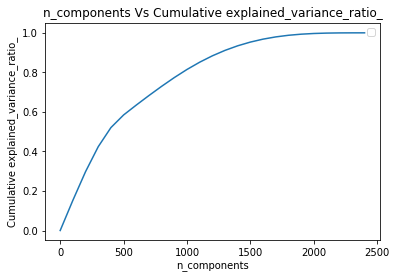

Best value of n_components is : 2400


In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
x=[]
y=[]
for k in range(0,2500,100):
    
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=42)
    svd.fit(cooccurrence_matrix)  
    x.append(k)
    y.append(svd.explained_variance_ratio_.sum())  
    
plt.plot(x, y)

plt.legend()
plt.xlabel("n_components")
plt.ylabel("Cumulative explained_variance_ratio_")

plt.title("n_components Vs Cumulative explained_variance_ratio_")
plt.show()
best = y.index(max(y))
print("Best value of n_components is :",x[best])


In [63]:
print("Best value of n_components is :",x[best],max(y))

Best value of n_components is : 2400 0.9999969768100898


In [47]:
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
svd.fit(cooccurrence_matrix)  
svd.explained_variance_ratio_.sum()

0.9967011075365129

In [48]:
svd.components_[0]

array([4.90735670e-05, 7.94026088e-05, 1.16891272e-04, ...,
       1.16891272e-04, 7.94026088e-05, 4.90735670e-05])

In [53]:
svd.components_[:2].shape

(2, 2500)

In [59]:
sp_matr[1].toarray()

array([[-9.81473216e-05, -1.58804331e-04, -2.33780329e-04, ...,
         2.33780786e-04,  1.58805058e-04,  9.81472119e-05]])

In [60]:
tf_idf.inverse_transform(sp_matr[1].toarray())
#svd.components_

[array(['aa', 'aafco', 'aback', ..., 'away great', 'away home',
        'away many'], dtype='<U27')]

In [57]:
svd_mtrx = np.asmatrix(svd.components_)

In [58]:
import scipy
sp_matr = scipy.sparse.csr_matrix(svd.components_)

In [52]:
tf_idf.inverse_transform(matrx[1])

[array(['dogs', 'china', 'made', 'love', 'saw', 'pet', 'store', 'tag',
        'attached', 'regarding', 'satisfied', 'safe', 'dogs love',
        'pet store', 'made china'], dtype='<U27')]

In [61]:
tf_idf.inverse_transform(sp_matr[4])

[array(['aa', 'aafco', 'aback', ..., 'away great', 'away home',
        'away many'], dtype='<U27')]

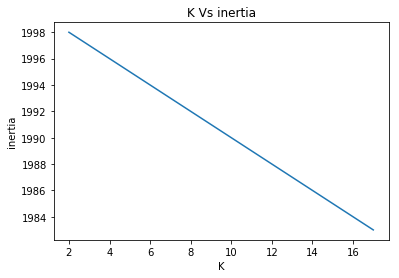

Best value of K is : 17


In [56]:
     
from sklearn.cluster import KMeans
x =[]
y =[]
z =[]

for i in range(2,20,3):
    clf = KMeans(n_clusters=i,n_jobs=-1)
    
    # fitting the model on crossvalidation train
    clf.fit(svd.components_)
    
    acc = clf.inertia_
   
    x.append(i)
    y.append(acc)
   



plt.plot(x,y)

plt.xlabel("K")
plt.ylabel("inertia")

plt.title("K Vs inertia")
plt.show()
best = y.index(min(y))
print("Best value of K is :",x[best])



In [127]:
clf = KMeans(n_clusters=2,n_jobs=-1)
    
    # fitting the model on crossvalidation train
clf.fit(svd.components_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [128]:
silhouette_score(svd.components_,clf.labels_)


-2.917913208361342e-14

In [129]:
d=[]
for s in clf.labels_:
    if s not in d:
        d.append(s)
print(d)

[0, 1]


In [125]:
s0 = ""
s1 = ""
c=0
for i in clf.labels_:
    if i == 0 :
        for j in tf_idf.inverse_transform(svd.components_[c]):
            for k in j:
                if k in s0:
                    pass
                else:
                    s0+=k
                    s0+=" "
        c+=1
    else:
        for j in tf_idf.inverse_transform(svd.components_[c]):
            for k in j:
                if k in s1:
                    pass
                else:
                    s1+=k
                    s1+=" "
        c+=1
   

KeyboardInterrupt: 

In [ ]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 

#Cluster of words for positive rating(1)  
wordcloud = WordCloud(width = 1600, height = 800, max_words=10000,
                background_color ='white', 
                min_font_size = 10).generate(s1) 
  



In [ ]:
# plot the WordCloud image  

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 

plt.margins(x=0, y=0) 
plt.show() 

In [55]:
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

In [56]:
svd.components_[0].ravel()

array([4.90735670e-05, 7.94026088e-05, 1.16891272e-04, ...,
       1.16891272e-04, 7.94026088e-05, 4.90735670e-05])

In [57]:
cosine_similarity(svd.components_[0].reshape(-1,1),svd.components_[1].reshape(-1,1))

array([[-1., -1., -1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       ...,
       [-1., -1., -1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1.,  1.,  1.]])

In [78]:
from scipy import spatial

result = 1 - spatial.distance.cosine(svd.components_[0],svd.components_[1])
result

2.220446049250313e-16

In [104]:
type(svd.components_[0])

numpy.ndarray

In [108]:
tf_idf.transform(['hello']).toarray()[0].shape

(11762,)

In [59]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine



dist_out = 1-pairwise_distances(svd.components_, metric="cosine")
dist_out.shape

(2400, 2400)

In [60]:
max(dist_out.ravel())

1.0

In [89]:
tf_idf.transform(['hello'])[0]

<1x11762 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [133]:
tf_idf.inverse_transform(svd.components_[0])

AttributeError: 'list' object has no attribute 'shape'

In [119]:
def most_similar(word,count):
    vec = tf_idf.transform([word]).toarray()[0]
    diff=[]
    for i in svd.components_:
        diff.append(1 - spatial.distance.cosine(i,vec))
    return diff


In [131]:
dif = most_similar("ability",10)

In [134]:
np.argsort(dif)

array([4013, 3639, 3824, ..., 3553, 3339, 2605])

In [135]:
dif[2605]

0.048013430053859496

In [142]:
tf_idf.inverse_transform(svd.components_[2605])

AttributeError: 'list' object has no attribute 'ravel'

In [150]:
for i in tf_idf.inverse_transform(svd.components_[1]):
    print(list(i))

['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able give', 'able make', 'able order', 'able purchase', 'able use', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely amazing', 'absolutely best', 'absolutely delicious', 'absolutely love', 'absolutely loved', 'absolutely loves', 'absolutely no', 'absolutely wonderful', 'absorb', 'absorbed', 'abundant', 'acacia', 'acai', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'according', 'account', 'accurate', 'accustomed', 'acerola', 'acerola juice', 'ache', 'acid', 'acid reflux', 'acid vitamin', 'acidic', 'acidic taste', 'acidity', 'acids', 'acquired', 'acquired taste', 'across', 'act', 'acting', 'action', 'active', 'activity', 'acts', 'actual', 'actually', 'actually eat', 'actually good', 'actually got', 'actually like', 'actually not', 'actually pretty', 'actually quite', 'actually taste', 'actually tasted', 'actually tastes', 'actually think', 'actually use', 'ad', 'a